In [10]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [11]:
def feature_extraction(signal,feature_dictionary,f_peak):
    feature=[]
    
    if(feature_dictionary["fft_peak_frequencies"]==1):
        feature=np.concatenate((feature,f_peak.reshape(f_peak.shape[1])), axis=0);
        
    if(feature_dictionary["mean"]==1):
        mean=np.mean(signal);
        feature=np.concatenate((feature,[mean]), axis=0)
    
    if(feature_dictionary["variance"]==1):
        variance=np.var(signal)
        feature=np.concatenate((feature,[variance]), axis=0)
    #crest factor 
    if(feature_dictionary["crest_factor"]==1):
        crest_factor=np.sum(np.power(signal,2))/signal.size
        feature=np.concatenate((feature,[crest_factor]), axis=0)
    
    return np.asarray(feature)
#.reshape([feature.size,1])


def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
    


In [12]:

def export_signals(channels):
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    # for NIRS signal ==80 
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix
    

# EEG 

In [13]:
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')


channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

"""pick_yes_EEG_contents = sio.loadmat('pick_EEG_yes_signal.mat')
pick_no_EEG_contents = sio.loadmat('pick_EEG_no_signal.mat')"""
features_extracted_yes=sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no=sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes=sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no=sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']


# select which feature select
feature_dictionary = {
        "fft_peak_frequencies" : 0, 
         "mean" : 0, 
         "variance" : 0,
         "crest_factor" : 0
         }




channels_structure_yes_EEG=export_signals(channels_yes_EEG)
channels_structure_no_EEG=export_signals(channels_no_EEG)


"""features_extracted={
    "peak_signal" : pick_yes_EEG_contents,
        }
"""

train_TX_yes_EEG,EEG_yes_labels=get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

"""features_extracted={
    "peak_signal" : pick_no_EEG_contents,
}"""


train_TX_no_EEG,EEG_no_labels=get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);



train_TX=np.concatenate((train_TX_yes_EEG,train_TX_no_EEG,),axis=0)

print(train_TX.shape)
labels=np.concatenate((EEG_yes_labels,EEG_no_labels),axis=0)

print(train_TX)


(60, 386)
[[ 51.37899203  15.24531078  11.61436394 ...,   0.69780851   0.64827533
    0.55726964]
 [ 43.21884095  17.07002619  11.85487222 ...,   0.77119732   0.59796647
    0.52598179]
 [ 51.22274078  15.98498462  10.37548838 ...,   0.71748761   0.59170141
    0.44830244]
 ..., 
 [ 40.94839095  13.25256653  10.57481527 ...,   0.79197563   0.69576433
    0.55609014]
 [ 47.85958135  13.49252457   9.85585227 ...,   0.60220187   0.72432369
    0.48484489]
 [ 56.54235824  18.5951394   10.17135353 ...,   0.92023203   0.70894941
    0.60492243]]


In [14]:
# REGULARIZATION
degrees = np.array([1])
lambdas = np.logspace(-8,-2,6)
k_fold=10
seed = 2
max_iters = 5000
print(train_TX.shape)

best_deg,best_lambda, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_logistic_regularized(labels,train_TX, degrees, lambdas, k_fold, seed, max_iters)



(60, 386)
--- Fold 0 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
1.0
>> Lambda 1.58489319246e-07 <<
1.0
>> Lambda 2.51188643151e-06 <<
1.0
>> Lambda 3.98107170553e-05 <<
1.0
>> Lambda 0.00063095734448 <<
1.0
>> Lambda 0.01 <<
0.833333333333
--- Fold 1 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
0.833333333333
>> Lambda 1.58489319246e-07 <<
0.833333333333
>> Lambda 2.51188643151e-06 <<
0.666666666667
>> Lambda 3.98107170553e-05 <<
0.666666666667
>> Lambda 0.00063095734448 <<
0.5
>> Lambda 0.01 <<
0.666666666667
--- Fold 2 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
1.0
>> Lambda 1.58489319246e-07 <<
1.0
>> Lambda 2.51188643151e-06 <<
1.0
>> Lambda 3.98107170553e-05 <<
1.0
>> Lambda 0.00063095734448 <<
0.833333333333
>> Lambda 0.01 <<
0.5
--- Fold 3 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
1.0
>> Lambda 1.58489319246e-07 <<
1.0
>> Lambda 2.51188643151e-06 <<
1.0
>> Lambda 3.98107170553e-05 <<
1.0
>> Lambda 0.00063095734448 <<
1.0
>> Lambda 0.01 <<
1.0
--- Fold 4 ---
++ Degree 1 ++
>> Lambda 1e-08 <<
1.0
>> L

60
0.888888888889


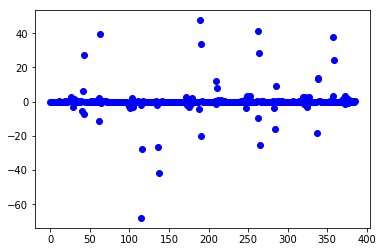

[  2.12167513e-03   6.59444226e-03  -5.76344889e-03   6.97418286e-02
  -3.29553643e-03   1.20737082e-02   5.59514454e-03   5.58557927e-02
  -1.40922601e-03   2.06229252e-03  -1.75663452e-02   1.24829243e-01
   9.24698639e-04  -3.14720022e-03   1.96465811e-02   5.82421668e-02
   7.89240611e-03   1.05346051e-02   1.18090145e-01   5.53977515e-02
   1.83287505e-02  -1.48697299e-03   1.97422257e-01   1.51299115e-01
   4.62970904e-01   4.18556205e-01   2.44136186e+00  -1.50256826e-01
   1.74217221e+00  -3.26642552e+00   1.53105031e+00   7.41412335e-01
  -2.56771657e-03   1.16006250e-02   7.24425550e-03   2.52584381e-01
  -1.57168698e-02   1.15619112e-02  -7.60444361e-03   3.83089361e-01
  -5.62747117e+00   6.03793157e+00   2.71070390e+01  -7.18477630e+00
  -1.00749897e-02  -6.54403277e-02  -1.46356862e-02  -3.85194063e-02
  -1.12198629e-03   4.62044153e-03  -2.92985250e-02   1.24226196e-01
  -7.25232833e-04   1.83458515e-03   1.64488183e-02   1.31552492e-01
  -3.02219083e-03   6.94407369e-03

In [15]:
#LOGISTIC 

max_iters = 100000
[i1,i2]=split_matrix_two_blocks(train_TX,0.7,0.3,2)

# TRAIN SET 

train=train_TX[i1,:]
labels_train=labels[i1]

# TEST SET
test= train_TX[i2,:]
labels_test=labels[i2]


logreg = linear_model.LogisticRegression(penalty='l1',C=1/best_lambda,max_iter=max_iters)


logreg.fit(train, labels_train)  
predicted_labels= logreg.predict(test)


logistic_accuracy=get_accuracy(predicted_labels, labels_test)
print(logistic_accuracy)

plt.plot(logreg.coef_[0],'bo')
plt.show()
print(logreg.coef_[0])
th=np.mean(np.abs(logreg.coef_[0]/10))

train_TX=select_features(logreg.coef_[0],train_TX,th)

print(train_TX.shape)

In [60]:
C_parameters= np.linspace(0.1,5,10)
k_fold=30 # number of k sub-folders to divide the set
seed = 2
max_iters = 100
kernel_types=['linear', 'rbf', 'sigmoid']
print(train_TX.shape)

best_C, best_kernel_type ,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels,train_TX, C_parameters, kernel_types, k_fold, seed, max_iters)



    

(60, 65)
--- Fold 0 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.5 0.793103448276
>> Type of Kernel  rbf <<
1.0 0.586206896552
>> Type of Kernel  sigmoid <<
1.0 0.586206896552
>> Penalty parameter C 0.644444444444 <<
>> Type of Kernel  linear <<
0.5 0.896551724138
>> Type of Kernel  rbf <<
1.0 0.603448275862
>> Type of Kernel  sigmoid <<
1.0 0.586206896552
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
0.5 0.931034482759
>> Type of Kernel  rbf <<
1.0 0.689655172414
>> Type of Kernel  sigmoid <<
1.0 0.586206896552
>> Penalty parameter C 1.73333333333 <<
>> Type of Kernel  linear <<
0.5 0.948275862069
>> Type of Kernel  rbf <<
1.0 0.724137931034
>> Type of Kernel  sigmoid <<
0.5 0.655172413793
>> Penalty parameter C 2.27777777778 <<
>> Type of Kernel  linear <<
0.5 0.948275862069
>> Type of Kernel  rbf <<
0.5 0.793103448276
>> Type of Kernel  sigmoid <<
1.0 0.603448275862
>> Penalty parameter C 2.82222222222 <<
>> Type of Kernel  linear <<
0.5 0.

0.5 0.551724137931
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
0.5 0.965517241379
>> Type of Kernel  rbf <<
0.5 0.724137931034
>> Type of Kernel  sigmoid <<
0.5 0.551724137931
>> Penalty parameter C 1.73333333333 <<
>> Type of Kernel  linear <<
0.5 0.965517241379
>> Type of Kernel  rbf <<
0.5 0.741379310345
>> Type of Kernel  sigmoid <<
0.5 0.551724137931
>> Penalty parameter C 2.27777777778 <<
>> Type of Kernel  linear <<
0.5 0.98275862069
>> Type of Kernel  rbf <<
0.5 0.775862068966
>> Type of Kernel  sigmoid <<
0.5 0.568965517241
>> Penalty parameter C 2.82222222222 <<
>> Type of Kernel  linear <<
0.5 0.98275862069
>> Type of Kernel  rbf <<
0.5 0.810344827586
>> Type of Kernel  sigmoid <<
0.5 0.655172413793
>> Penalty parameter C 3.36666666667 <<
>> Type of Kernel  linear <<
0.5 0.98275862069
>> Type of Kernel  rbf <<
0.5 0.827586206897
>> Type of Kernel  sigmoid <<
0.5 0.672413793103
>> Penalty parameter C 3.91111111111 <<
>> Type of Kernel  linear <<
0.5 0

1.0 0.741379310345
>> Type of Kernel  sigmoid <<
0.5 0.603448275862
>> Penalty parameter C 2.82222222222 <<
>> Type of Kernel  linear <<
1.0 0.948275862069
>> Type of Kernel  rbf <<
1.0 0.793103448276
>> Type of Kernel  sigmoid <<
0.5 0.655172413793
>> Penalty parameter C 3.36666666667 <<
>> Type of Kernel  linear <<
1.0 0.965517241379
>> Type of Kernel  rbf <<
1.0 0.810344827586
>> Type of Kernel  sigmoid <<
1.0 0.689655172414
>> Penalty parameter C 3.91111111111 <<
>> Type of Kernel  linear <<
1.0 0.965517241379
>> Type of Kernel  rbf <<
1.0 0.827586206897
>> Type of Kernel  sigmoid <<
1.0 0.672413793103
>> Penalty parameter C 4.45555555556 <<
>> Type of Kernel  linear <<
1.0 0.98275862069
>> Type of Kernel  rbf <<
1.0 0.810344827586
>> Type of Kernel  sigmoid <<
1.0 0.672413793103
>> Penalty parameter C 5.0 <<
>> Type of Kernel  linear <<
1.0 0.98275862069
>> Type of Kernel  rbf <<
1.0 0.827586206897
>> Type of Kernel  sigmoid <<
1.0 0.655172413793
--- Fold 17 ---
>> Penalty paramet

0.5 0.862068965517
>> Type of Kernel  sigmoid <<
0.5 0.672413793103
>> Penalty parameter C 5.0 <<
>> Type of Kernel  linear <<
0.5 0.98275862069
>> Type of Kernel  rbf <<
0.5 0.862068965517
>> Type of Kernel  sigmoid <<
0.5 0.672413793103
--- Fold 25 ---
>> Penalty parameter C 0.1 <<
>> Type of Kernel  linear <<
0.5 0.844827586207
>> Type of Kernel  rbf <<
0.5 0.603448275862
>> Type of Kernel  sigmoid <<
0.5 0.551724137931
>> Penalty parameter C 0.644444444444 <<
>> Type of Kernel  linear <<
0.5 0.896551724138
>> Type of Kernel  rbf <<
0.5 0.620689655172
>> Type of Kernel  sigmoid <<
0.5 0.551724137931
>> Penalty parameter C 1.18888888889 <<
>> Type of Kernel  linear <<
0.5 0.896551724138
>> Type of Kernel  rbf <<
0.5 0.706896551724
>> Type of Kernel  sigmoid <<
0.5 0.551724137931
>> Penalty parameter C 1.73333333333 <<
>> Type of Kernel  linear <<
0.5 0.896551724138
>> Type of Kernel  rbf <<
0.5 0.741379310345
>> Type of Kernel  sigmoid <<
0.5 0.637931034483
>> Penalty parameter C 2.2

In [26]:
best_C=0.1;
best_kernel_type= best_kernel_type
print(train_TX.shape[0])

780


In [61]:
from sklearn import svm
best_C=best_C;
seed=np.random.rand()
best_kernel_type=best_kernel_type
dataset_length=train_TX.shape[0];

for single_seed in seed:
    [i1,i2]=split_matrix_two_blocks(train_TX,0.7,0.3,single_seed)
    train=train_TX[i1,:]
    labels_train=labels[i1]
    test= train_TX[i2,:]
    labels_test=labels[i2]
    clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
    clf.fit(train, labels_train)  
    predicted_labels= clf.predict(test)


    SVM_accuracy=get_accuracy(predicted_labels, labels_test)
    print(SVM_accuracy)
    

60
0.666666666667
60
0.833333333333
60
0.722222222222
60
0.666666666667
60
0.777777777778
60
0.722222222222
60
0.777777777778
60
0.388888888889
60
0.777777777778
60
0.666666666667
60
0.611111111111
60
0.611111111111
60
0.666666666667
60
0.833333333333
60
0.833333333333
60
0.611111111111
60
0.777777777778
60
0.722222222222
60
0.611111111111
60
0.666666666667
60
0.722222222222
60
0.555555555556
